# IRP - ByteTrack tracker Guide

This notebook guides on how to used the Tracker developed during this IRP based on the original ByteTrack model.<br>

# Setup

Verify that the required packages are correctly installed and import the Tracker

In [1]:
pip install -r "../requirements.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.5 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 41.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.157 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
Setup complete ✅ (2 CPUs, 15.6 GB RAM, 4958.9/8062.4 GB disk)


In [3]:
import sys
import os

import matplotlib.pyplot as plt
import cv2
from glob import glob 

import warnings
warnings.filterwarnings("ignore")

sys.path.append('..')

from ByteTrack import Tracker

# 1. Tracking Model

In [4]:
model = Tracker(model="../ByteTrack/weights/best.pt")

In [5]:
print(model.__doc__)


    Tracking algorithm. This algorithm applies a 'Tracking-by-Detection' pipeline.
    The object detector is a combination of Ultralytics Yolov8 detection model and a Background Removal Motion Detector
    The Association algorithm is a variation of the BYTE algorithm applying a filtering step to remove outlier detections.
    
    Args:
        model (str): Path the a YOLO model
    
    Attributes:
        YOLO (ultralytics.YOLO): YOLO detection model
        CLASS_NAMES_DICT (DICT[int, str]): List of the different objects type
        motion_detector (): Motion Detection algorithm
        frame_memory (List): List of the processed frame in the same frame sequence
        VideoWriter (): OpenCV Video Writer
        Annotator (): Frame Annotator object
        save_dir (str): Default save directory
        _save_dir (dir): Save Directory currently in use
        nb_frame (int): Number of frame that have already been processed
        trackers (List): List of the used trackers 

    

# 2. Predict and Track

There are three different ways to perform tracking:

1. Process each frame one by one. In this case, the keyword "persist" should be set to True to inform the algorithm that the frames are part of the same sequence. Setting "persist" to False would reset the trackers memory.
2. Perform tracking on a folder containing a frame sequence. All the frames will be directly processed one by one. The tracker will not be reset at the end of tracking.
3. Perform tracking on a video file. In this case, each frame would be first extracted and processed one by one. Again, the tracker will not be reset at the end of tracking.

The output of the tracking function corresponds to the tracking results (bounding boxes, labels, confidence score, and tracking ID) as a List of Ultralytics.engine.results objects. In addition, the user can choose to save the tracking results during the process as text files. The annotated frames can also be saved as jpg files and they can be directly combined to save a video file. When processing frames one by one, the VideoWriter won't be released directly after tracking.

The video format can be precised by passing a video file name as input. 

In [6]:
print(model.track.__doc__)


        Run tracking algorithm on given input source.
        
        Args:
            source (): Data to use for tracking. Can be frames or directory
            tracker (str): path to the tracker configuration file
            persist (bool): Flag to reinitialise the tracking memory
            save_video (bool): whether to save the annotated frames as a video
            video (str): Name of the video. Only used if 'save_video' is True
            fps (int): FPS value to use for the video. If None and not available in the source, the results won't be saved as a video
            save_txt (bool): whether to save the tracking results in txt files
            save_frame (bool): whether to save the annotated frames
            use_yolo (bool): Whether to use the YOLO model for object detection
            use_motion_detector (bool): Whether to use the Motion Detector for object detection
            iou_merge (float): IoU threshold for detection merging between YOLO and MotionDetecto

In [7]:
# Get the path to a video or image sequence
data_path = "../IRP_dataset/test/Test_13"

# Get the fps saved in the same folder
with open(os.path.join(data_path, "meta_info.txt"), "r") as f:
    meta_info = [line[:-1] if line[-1] == '\n' else line for line in f.readlines()]
    
fps = int(meta_info[4].split(" ")[-1])

# List of frames
lst_frames = sorted(glob(os.path.join(data_path, '*.jpg')))

for file in lst_frames:
    frame = cv2.imread(file)

    results = model.track(frame, persist=True, save_video=True, save_txt=True, save_frame=True, verbose=True, fps=fps)

YOLO + MotionDetector + BYTETRACK Tracker. Tracking Started: 

image 1/1 img0.jpg: 720x1280 13 birds, 22941.769ms
Results saved to runs/track
image 1/1 img0.jpg: 720x1280 13 birds, 226.832ms
Results saved to runs/track
image 1/1 img0.jpg: 720x1280 14 birds, 138.101ms
Results saved to runs/track
image 1/1 img0.jpg: 720x1280 14 birds, 141.261ms
Results saved to runs/track
image 1/1 img0.jpg: 720x1280 13 birds, 1 other, 142.843ms
Results saved to runs/track
image 1/1 img0.jpg: 720x1280 14 birds, 139.188ms
Results saved to runs/track
image 1/1 img0.jpg: 720x1280 13 birds, 138.461ms
Results saved to runs/track
image 1/1 img0.jpg: 720x1280 13 birds, 139.716ms
Results saved to runs/track
image 1/1 img0.jpg: 720x1280 13 birds, 148.244ms
Results saved to runs/track
image 1/1 img0.jpg: 720x1280 13 birds, 135.823ms
Results saved to runs/track
image 1/1 img0.jpg: 720x1280 12 birds, 1 other, 191.481ms
Results saved to runs/track
image 1/1 img0.jpg: 720x1280 13 birds, 1 other, 132.843ms
Results save

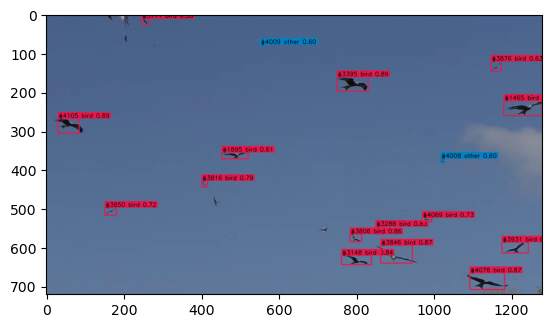

In [8]:
# Plot the last annotated frame
plt.imshow(model.frame_memory[-1][:,:,::-1]);

In [9]:
# Reset the trackers memory
model.reset_tracker()

In [10]:
# Perform tracking on a folder containing an image sequence
# The fps value is not needed here as it will be directly read from the 'meta_info.txt' file

results = model.track(data_path, save_video=True, save_txt=True, save_frame=True, verbose=True)

YOLO + MotionDetector + BYTETRACK Tracker. Tracking Started: 

image 1/674 /kaggle/input/irp-dataset/test/test/data/bird81/029538.jpg: 720x1280 13 birds, 360.148ms
image 2/674 /kaggle/input/irp-dataset/test/test/data/bird81/029539.jpg: 720x1280 13 birds, 167.013ms
image 3/674 /kaggle/input/irp-dataset/test/test/data/bird81/029540.jpg: 720x1280 14 birds, 132.530ms
image 4/674 /kaggle/input/irp-dataset/test/test/data/bird81/029541.jpg: 720x1280 14 birds, 134.029ms
image 5/674 /kaggle/input/irp-dataset/test/test/data/bird81/029542.jpg: 720x1280 13 birds, 1 other, 139.160ms
image 6/674 /kaggle/input/irp-dataset/test/test/data/bird81/029543.jpg: 720x1280 14 birds, 137.275ms
image 7/674 /kaggle/input/irp-dataset/test/test/data/bird81/029544.jpg: 720x1280 13 birds, 132.385ms
image 8/674 /kaggle/input/irp-dataset/test/test/data/bird81/029545.jpg: 720x1280 13 birds, 138.540ms
image 9/674 /kaggle/input/irp-dataset/test/test/data/bird81/029546.jpg: 720x1280 13 birds, 135.028ms
image 10/674 /kaggl

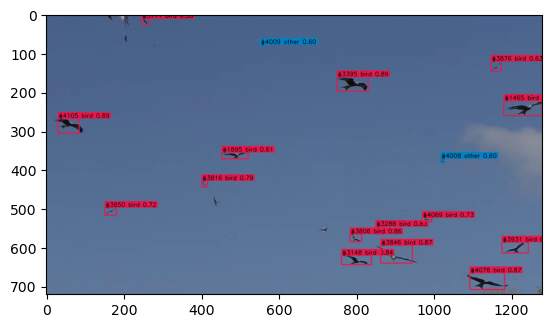

In [11]:
# Plot the last annotated frame
plt.imshow(model.frame_memory[-1][:,:,::-1]);

# 3. Validation



In [12]:
model = Tracker(model="../ByteTrack/weights/best.pt")

In [13]:
print(model.validate.__doc__)


        Validate the tracking algorithm on given input source.
        
        Args:
            source (): Data to use for tracking. Can be frames or directory
            tracker (str): path to the tracker configuration file
            use_yolo (bool): Whether to use the YOLO model for object detection
            use_motion_detector (bool): Whether to use the Motion Detector for object detection
            iou_merge (float): IoU threshold for detection merging between YOLO and MotionDetector predictions
            kwargs: Other arguments for the YOLO model. See Ultralytics for more info
        
        Returns:
            results (List[Ultralytics.engine.results]): List of predicted objects for the input source
            frames (List[np.ndarray]): List of the frames annotated with the tracking results
        


In [14]:
# Path to the validation folder. It should contain a 'labels' and an 'image' folder
source = "../IRP_dataset/val"

YOLO + MotionDetector + BYTETRACK Tracker: Tracker Validation
100%|██████████| 5/5 [01:48<00:00, 21.67s/it]
Mean Tracking Speed: 5.242 frames/second


Count: ByteTrack         Dets      GT_Dets   IDs       GT_IDs    
0                        2629      3291      80        41        
1                        3428      3945      152       52        
2                        2539      2989      74        41        
3                        1791      2042      57        26        
4                        1199      1971      37        26        
COMBINED                 11586     14238     400       186       

CLEAR: ByteTrack         MOTA      MOTP      MODA      CLR_Re    CLR_Pr    MTR       PTR       MLR       sMOTA     CLR_TP    CLR_FN    CLR_FP    IDSW      MT        PT        ML        Frag      
0                        23.579    71.524    24.521    52.203    65.348    29.268    36.585    34.146    8.7143    1718      1573      911       31        12        15        14        128  

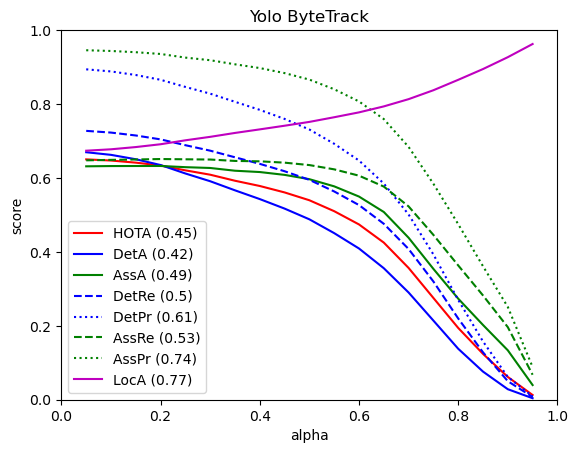

<Figure size 640x480 with 0 Axes>

In [15]:
# Perform Validation
metrics = model.validate(source)